In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import netCDF4
from erddapy import ERDDAP
import json

Configure the ERDDAP to search

In [2]:
ra = 'nanoos'

with open('utils/ra_erddaps.json') as f:
    urls = json.load(f)

server = urls[ra.lower()]

print(server)

e = ERDDAP(server=server, protocol="tabledap")

http://data.nanoos.org/erddap


Pull in the processed inventory

In [3]:
#
# df_cruise = df[df['Station Description'] == 'Chesapeake Bay WQ Cruise Data ']
#
#df_aws = df[df['Station ID'] == 'Humboldt']
# #url = 'http://tds.glos.us/thredds/dodsC/buoy_agg_standard/OMOECC_E1/OMOECC_E1.ncml'
# #url = 'http://tds.glos.us/thredds/dodsC/buoy_agg_standard/45186/45186.ncml'
# #url = 'http://tds.glos.us/thredds/dodsC/buoy_agg_standard/bgsusd2/bgsusd2.ncml'
# url = 'http://oos.soest.hawaii.edu/thredds/dodsC/hioos/nss/ns12agg'
# print(url)
# ds = xr.open_dataset(url)
# #ds = netCDF4.Dataset(url,'r')
# title = ds.title
# start_time = np.datetime_as_string(ds.time.min().values, unit='D')
# end_time = np.datetime_as_string(ds.time.max().values, unit='D')
# print('Duration: %s - %s' % (np.datetime_as_string(ds.time.min().values, unit='D'),
#                              np.datetime_as_string(ds.time.max().values, unit='D'))
#       )

# Try glos web server
# url = 'https://glbuoys.glos.us/tools/export?ftype=csv&data_type=buoy&units=eng&locs=OMOECC_E1&params=Water_Temperature_at_Surface|dissolved_oxygen_saturation|water_conductivity|ysi_turbidity&tperiod=custom&date_start=2020-01-01&date_end=2020-12-31&avg_ivld=none'
# df = erddapy.ERDDAP.to_pandas(url)

## using ERDDAP to look for stations
# check out http://data.glos.us/erddap/tabledap/allDatasets.htmlTable?datasetID%2Ctitle%2CminTime%2CmaxTime&maxTime%3E=2020-01-01&maxTime%3C=2020-12-31&orderBy(%22maxTime%22)
# that lists out all the GLOS stations with the maximum time of observations within the year 2020 (on their ERDDAP).

df = pd.read_excel('2021/data/processed/%s.xlsx' % ra.upper())
df

,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude (dec deg),Longitude (dec deg),Platform Type,"Station Deployment (mm/yyyy, yyyy, < 5 yr, > 5 yr)","Currently Operational? (Y, N, O, U)",Platform Funder/Sponsor,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,"Variable Names + water column depth of measurement in meters [CF_name (# m, # m) or CF_name (mult) or CF_name (# depths)].",Additional notes
0,APL-UW ESP,NaN,APL-UW ESP Mooring,NaN,47.9717,-124.9533,moored buoy,08/2011,Y,NaN,Yp,Applied Physics Laboratory-University of Washi...,Academic,APL-UW,APL-UW,N/A (see notes),No WMO ID because this asset does not serve da...
1,APL-UW NEMO Profiler,NaN,APL-UW NEMO-ESP Profiler,NaN,47.9667,-124.9549,profiling buoy,08/2011,Y,NaN,Yf,APL-UW,Academic,APL-UW,APL-UW,"sea_water_electrical_conductivity (profiling),...",No WMO ID established yet; profiling from\n~20...
2,APL-UW Chaba,46119,Chaba UW/NANOOS Moored Buoy near La Push,NaN,47.9676,-124.9600,moored buoy,07/2010,Y,NaN,Yp,APL-UW,Academic,APL-UW,APL-UW,"air_temperature, surface_air_pressure, surface...",NaN
3,CMOP Saturn 02,46096,SATURN-02,NaN,46.1735,-124.1272,moored buoy,05/2006,Y,NaN,Yp,CRITFC,Tribal,CRITFC,CRITFC,"air_temperature, surface_air_pressure, surface...",NaN
4,CMOP Saturn 03,SETO3,SATURN-03,NaN,46.1997,-123.9400,fixed shore platform,04/2008,Y,NaN,Yp,CRITFC,Tribal,CRITFC,CRITFC,mass_concentration_of_chlorophyll_in_sea_water...,NaN
5,CMOP Saturn 04,SEFO3,SATURN-04,NaN,46.2036,-123.7586,fixed shore platform,11/2001,Y,NaN,Yp,CRITFC,Tribal,CRITFC,CRITFC,concentration_of_colored_dissolved_organic_mat...,NaN
6,CMOP Saturn 05,SRFW1,SATURN River Station 05 (LOBO Station),NaN,46.1845,-123.1874,fixed shore platform,06/2009,O,NaN,N,CRITFC,Tribal,CRITFC,CRITFC,mass_concentration_of_chlorophyll_in_sea_water...,NaN
7,CMOP Saturn 07,46116,SATURN-07,NaN,46.2860,-124.0151,moored buoy,12/2012,Y,NaN,Yp,"Oregon Health Sciences University (OHSU), Port...","Academic, Federal","OHSU, PSU, USGS",CRITFC,mass_concentration_of_chlorophyll_in_sea_water...,NaN
8,CMOP Saturn 09,46117,SATURN-09,NaN,46.1765,-123.8693,fixed shore platform,09/2014,Y,NaN,Yp,CRITFC,Tribal,CRITFC,CRITFC,mass_concentration_of_chlorophyll_in_sea_water...,NaN
9,NERRS SOSCHWQ,CWQO3,"Station SOSCHWQ - Charleston Bridge, South Slo...",NaN,43.3380,-124.3210,fixed shore platform,01/2011,O,NaN,Yp,NERRS - South Slough,Federal,NERRS - South Slough,CDMO,mass_concentration_of_oxygen_in_sea_water (tid...,NaN


Search the ERDDAP server for a single station of interest - more of a test

In [4]:
df_wf = df[df['Station ID'] == 'Hakai KC Buoy']

# for SCCOOS need to search for 'Station Long Name' as 'Station ID' is NA for most entries
search_for = df_wf['Station ID'].to_string()

search_url = e.get_search_url(search_for=search_for, response="csv")

resp = pd.read_csv(search_url)

resp['Dataset ID']

HTTPError: HTTP Error 404: 

Rip through all the datasets in the inventory and see if they exist on the RA erddap. Process checks the following order:

1. `Station ID`, then 
2. `Station Long Name`

In [5]:
## TODO add a dictionary for `Station ID` to `Dataset ID` mapping. This will allow us to check if the `Station ID`
# has multiple `Dataset ID` but is collecting obs for the CY.

not_found = []
found = dict()

for station in df['Station ID'].astype(str):
    
    try:
        search_url = e.get_search_url(search_for=station, response="csv")
        resp = pd.read_csv(search_url)
        print("Found \"%s\": %s" % (station,resp['Dataset ID'].values.tolist()))
        
        found[station] = {'Dataset ID': resp['Dataset ID'].values.tolist()}
        
    except:
        
        not_found.append(station)
#        pass
        print('no dataset matching \"%s\"' % station)
        station_long_name = df.loc[df['Station ID'] == station,'Station Long Name'].values.tolist()[0]
        
        try:
            print('searching \"station long name\" = \"%s\"' % station_long_name)
            search_url = e.get_search_url(search_for=station_long_name, response="csv")
            resp = pd.read_csv(search_url)
            print("Found \"%s\": %s" % (station_long_name,resp['Dataset ID'].values.tolist()))
            
            found[station] = {'Dataset ID': resp['Dataset ID'].values.tolist()}
            
        except:
            print("No dice...")
            not_found.append(station)
        
    print("\n")

Found "APL-UW ESP": ['ORCA_Hoodsport', 'allDatasets', 'ORCA_Hansville', 'APL_NPB2Carr', 'APL_NPB1PtWells', 'ORCA_Dabobbay', 'ORCA_Twanoh']


no dataset matching "APL-UW NEMO Profiler"
searching "station long name" = "APL-UW NEMO-ESP Profiler"
No dice...


no dataset matching "APL-UW Chaba"
searching "station long name" = "Chaba UW/NANOOS Moored Buoy near La Push"
No dice...


Found "CMOP Saturn 02": ['gliderswwash_unit_092-20100929', 'gliderswwash_unit_251-20130718', 'gliderswwash_unit_092-20100830', 'gliderswwash_unit_092-20110412', 'gliderswwash_unit_092-20100416', 'gliderswwash_unit_092-20100708', 'gliderswwash_unit_092-20100512', 'gliderswwash_unit_092-20090723', 'gliderswwash_unit_092-20110901', 'gliderswwash_unit_092-20110722', 'gliderswwash_unit_092-20090517', 'gliderswwash_unit_251-20120725', 'gliderswwash_unit_251-20130508', 'gliderswwash_unit_092-20110620', 'gliderswwash_unit_092-20090610', 'gliderswwash_unit_092-20090901']


Found "CMOP Saturn 03": ['gliderswwash_unit_092-20

Print the stations that we couldn't find.

In [6]:
df[df['Station ID'].isin(not_found)]

,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude (dec deg),Longitude (dec deg),Platform Type,"Station Deployment (mm/yyyy, yyyy, < 5 yr, > 5 yr)","Currently Operational? (Y, N, O, U)",Platform Funder/Sponsor,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,"Variable Names + water column depth of measurement in meters [CF_name (# m, # m) or CF_name (mult) or CF_name (# depths)].",Additional notes
1,APL-UW NEMO Profiler,NaN,APL-UW NEMO-ESP Profiler,NaN,47.9667,-124.9549,profiling buoy,08/2011,Y,NaN,Yf,APL-UW,Academic,APL-UW,APL-UW,"sea_water_electrical_conductivity (profiling),...",No WMO ID established yet; profiling from\n~20...
2,APL-UW Chaba,46119,Chaba UW/NANOOS Moored Buoy near La Push,NaN,47.9676,-124.9600,moored buoy,07/2010,Y,NaN,Yp,APL-UW,Academic,APL-UW,APL-UW,"air_temperature, surface_air_pressure, surface...",NaN
9,NERRS SOSCHWQ,CWQO3,"Station SOSCHWQ - Charleston Bridge, South Slo...",NaN,43.3380,-124.3210,fixed shore platform,01/2011,O,NaN,Yp,NERRS - South Slough,Federal,NERRS - South Slough,CDMO,mass_concentration_of_oxygen_in_sea_water (tid...,NaN
10,NERRS SOSECWQ,SLOO3,"Station SOSECWQ - Elliot Creek, South Slough R...",NaN,43.2965,-124.3107,fixed shore platform,09/2012,Y,NaN,Yp,NERRS - South Slough,Federal,NERRS - South Slough,CDMO,mass_concentration_of_oxygen_in_sea_water (tid...,NaN
11,NERRS SOSTCMET,SNTO3,"Station SOSTCMET - Tom's Creek, South Slough R...",NaN,43.2791,-124.3184,land station,11/2016,Y,NaN,Yp,NERRS - South Slough,Federal,NERRS - South Slough,CDMO,"air_temperature, surface_air_pressure, surface...",NaN
12,NERRS SOSWIWQ,CHQO3,"Station SOSWIWQ - Winchester Arm, South Slough...",NaN,43.2820,-124.3200,fixed shore platform,01/2011,Y,NaN,Yp,NERRS - South Slough,Federal,NERRS - South Slough,CDMO,mass_concentration_of_oxygen_in_sea_water (tid...,NaN
13,SSNERR-CTCLUSI SOSNSWQ,NaN,SOSNSWQ Station - North Spit-BLM Boat Ramp nea...,NaN,43.4139,-124.2789,fixed shore platform,08/2014,Y,NaN,Yp,NERRS - South Slough,Federal,NERRS - South Slough,NWSHADS,mass_concentration_of_oxygen_in_sea_water (tid...,NaN
14,ORCA Carr Inlet,46121,Profiling Buoy at Carr Inlet - South Sound,NaN,47.2800,-122.7300,profiling buoy,10/2010,Y,NaN,Yp,APL-UW,Academic,APL-UW,APL-UW / Northwest Environmental Moorings (NWEM),"air_temperature, surface_air_pressure, dew_poi...",Profiling from surface to ~40m
21,Fanny Bay Oysters,NaN,"Fanny Bay Oysters, Baynes Sound",NaN,49.4716,-124.7927,fixed shore platform,03/2017,Y,NaN,N,Fanny Bay Oysters,Industry,Hakai Institute/ Fanny Bay Oysters,Hakai Institute,"total_alkalinity (6m), surface_partial_pressur...",NaN
22,FHL-UW Friday Harbor,NaN,UW Friday Harbor Laboratories Cantilever Pt,NaN,48.5461,-123.0077,land station,2006,Y,NaN,N,Friday Harbor Laboratory (FHL) - UW,Academic,FHL-UW,FHL-UW,"air_temperature, surface_downwelling_photosynt...",NaN


In [7]:
found

{'APL-UW ESP': {'Dataset ID': ['ORCA_Hoodsport',
   'allDatasets',
   'ORCA_Hansville',
   'APL_NPB2Carr',
   'APL_NPB1PtWells',
   'ORCA_Dabobbay',
   'ORCA_Twanoh']},
 'CMOP Saturn 02': {'Dataset ID': ['gliderswwash_unit_092-20100929',
   'gliderswwash_unit_251-20130718',
   'gliderswwash_unit_092-20100830',
   'gliderswwash_unit_092-20110412',
   'gliderswwash_unit_092-20100416',
   'gliderswwash_unit_092-20100708',
   'gliderswwash_unit_092-20100512',
   'gliderswwash_unit_092-20090723',
   'gliderswwash_unit_092-20110901',
   'gliderswwash_unit_092-20110722',
   'gliderswwash_unit_092-20090517',
   'gliderswwash_unit_251-20120725',
   'gliderswwash_unit_251-20130508',
   'gliderswwash_unit_092-20110620',
   'gliderswwash_unit_092-20090610',
   'gliderswwash_unit_092-20090901']},
 'CMOP Saturn 03': {'Dataset ID': ['gliderswwash_unit_092-20100416',
   'gliderswwash_unit_092-20110412',
   'gliderswwash_unit_251-20130508',
   'gliderswwash_unit_251-20120725',
   'gliderswwash_unit_092

Check if the dataset has coverage for CY 2021

In [ ]:
valid_datasets = []

for key in found:
    
    dataset_id = found[key]['Dataset ID']
    
    if len(dataset_id)>1:
        
        for dataset in dataset_id:
            
            e.dataset_id = dataset
    
            e.constraints = {
                 "time>=": "2021-01-01"
            }
        
            e.variables = ['time']
    
            try:
                df_data = e.to_pandas(parse_dates=True)
                valid_datasets.extend([key])
                
            except:
                pass

                #print("No data for 2021 for %s: dataset ID %s" % (key,e.dataset_id))

    else:
        
        e.dataset_id = dataset_id[0]
    
        e.constraints = {
                         "time>=": "2021-01-01"
                        }
        
        e.variables = ['time']
        
        try:
            
            df_data = e.to_pandas(parse_dates=True)

            valid_datasets.extend([key])

        except:
            pass

            #print("No data for 2021 for %s: dataset ID %s" % (key,e.dataset_id))

            
#for valid in sorted(set(valid_datasets)):
    
#     # drop qc vars
#     cols = [c for c in df_data.columns if 'qc' not in c]
#     cols = [c for c in cols if 'QARTOD' not in c]

#     df_data = df_data[cols]

#     # set index for plotting
#     df_data = df_data.set_index(df_data['time (UTC)'])

#     # plot
#     #df_data.plot(subplots=True, title=e.dataset_id,figsize=(20,20))

#     start_time = df_data['time (UTC)'].min()
#     end_time = df_data['time (UTC)'].max()

#     print('Dataset %s' % e.dataset_id)
#     print('Duration: %s - %s' % (start_time, end_time))

non_2021_datasets = found.keys() - sorted(set(valid_datasets))

print('Datasets without coverage for 2021:\n%s' % non_2021_datasets)

Show me the inventory metadata about the invalid stations:

In [ ]:
bad_stations = df.loc[(df['Station ID'].isin(non_2021_datasets)) | df['Station ID'].isin(not_found)]

bad_stations

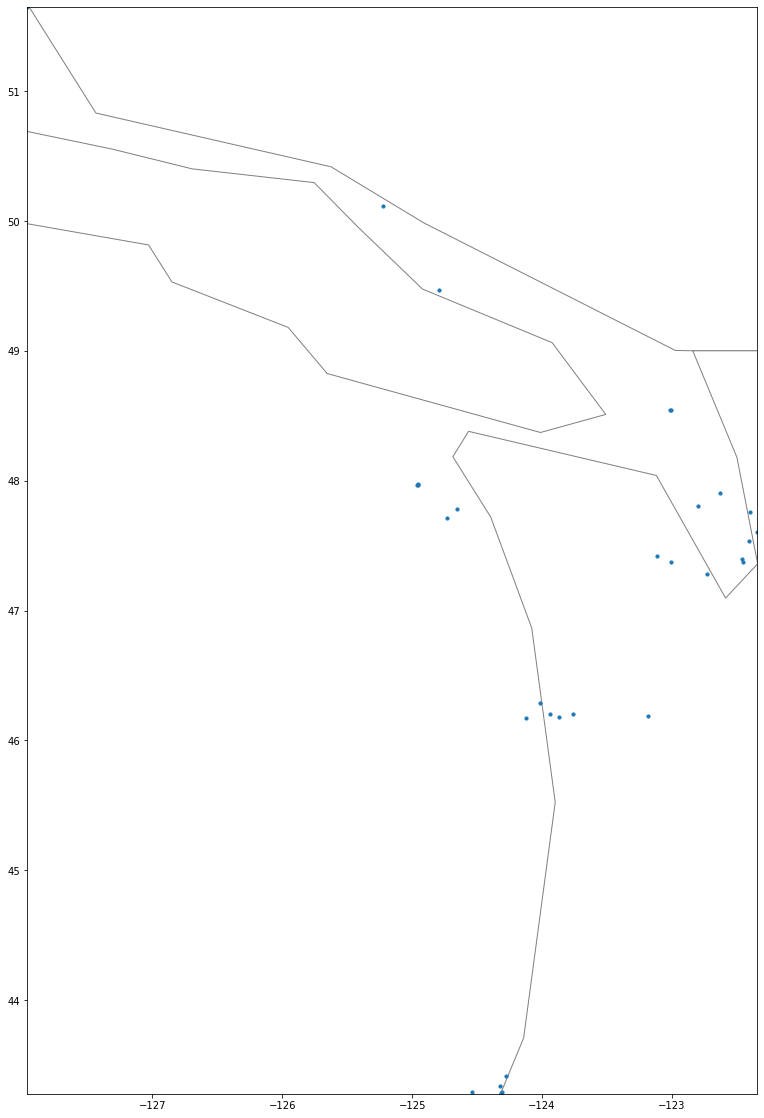

In [8]:
import geopandas
import matplotlib.pyplot as plt


df.rename(columns=
{'Variable Names + water column depth of measurement in meters [CF_name (# m, # m) or CF_name (mult) or CF_name (# depths)].':
     'Variable Names',
 'Station Deployment (mm/yyyy, yyyy, < 5 yr, > 5 yr)': 'Station Deployment',
 'Longitude (dec deg)': 'Longitude',
 'Latitude (dec deg)': 'Latitude'},
              inplace=True)

df['Station Deployment'] = \
    df['Station Deployment'].astype(str)


gdf = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df['Longitude'], df['Latitude']))

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

ax = world.plot(
    color='white', 
    edgecolor='grey', 
    figsize=(25,20),
    )

gdf.plot( ax=ax,
         #column='RA', 
         categorical=True, 
         markersize=10, 
         legend=True,
         k=11,
        )



minx, miny, maxx, maxy = gdf.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

plt.show()

In [9]:
gdf_final = gdf.set_crs(epsg=4326)

gdf_final.explore()

In [ ]:
gdf_final.loc[gdf_final['geometry'].is_empty == True]